# Question Classification

We used train dataset from https://github.com/amazonqa/amazonqa?tab=readme-ov-file to do this task. There are 17 product types of question inclucing 'Toys_and_Games', 'Health_and_Personal_Care', 'Cell_Phones_and_Accessories', 'Home_and_Kitchen', 'Musical_Instruments', 'Baby', 'Sports_and_Outdoors','Patio_Lawn_and_Garden', 'Video_Games', 'Pet_Supplies', 'Tools_and_Home_Improvement', 'Beauty', 'Electronics',       'Grocery_and_Gourmet_Food', 'Automotive', 'Office_Products','Clothing_Shoes_and_Jewelry'

## Experiment

We have trained 2 models (biLSTM and CNN) on different parameter with small (500 per product category) and large dataset (1000 per product category). Moreover, we saved the model when the validation loss is improve. Therefore, we select the best model with specific parameter based on minimum validation loss


Github link for our experiment: https://github.com/Noppawee-Teeraratchanon/NLP_Project_Question_Classification_By_ProductType.git

### biLSTM with small dataset

<img src = "question_classification_mlflow_image/biLSTM500_1.png">
<img src = "question_classification_mlflow_image/biLSTM500_2.png">

### biLSTM with large dataset

<img src = "question_classification_mlflow_image/biLSTM1000_1.png">
<img src = "question_classification_mlflow_image/biLSTM1000_2.png">

### CNN with small dataset

<img src = "question_classification_mlflow_image/CNN500.png">

### CNN with large dataset

<img src = "question_classification_mlflow_image/CNN1000.png">

From the experiment, we can conclude that both models are better when the dataset is larger. For biLSTM, when we increase the epoch, hidden dimension, and number of layers, the model is worse. For CNN, we can conclude that when the number of filters and epoch increase, the model is better
<br>

Based on minimum validation loss, CNN with 30 epochs, 150 number of filters is our best model and we will use it to train with a larger dataset (2000 dataset per category) in this jupyter.

In [1]:
import torch, torchdata, torchtext
import torch.nn as nn
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import time

C:\Users\earth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.__version__, torchdata.__version__, torchtext.__version__

('2.2.2+cpu', '0.7.1', '0.17.2+cpu')

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
SEED = 1234 #change three times
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## 1. load dataset

In [5]:
df = pd.read_json('../data/train-qar.jsonl', lines=True, nrows=300000)
df = df[['category', 'questionText']]
df.head(5)

,category,questionText
0,Toys_and_Games,"Many have stated similar to the following: ""Pa..."
1,Health_and_Personal_Care,Will these work with the Phillips sonicare han...
2,Cell_Phones_and_Accessories,What kind of sim card it use?
3,Home_and_Kitchen,does anyone know if this dinnerware set does n...
4,Musical_Instruments,I'm thinking of getting in to modular synthesi...


In [6]:
# Product category
df['category'].unique()

array(['Toys_and_Games', 'Health_and_Personal_Care',
       'Cell_Phones_and_Accessories', 'Home_and_Kitchen',
       'Musical_Instruments', 'Baby', 'Sports_and_Outdoors',
       'Patio_Lawn_and_Garden', 'Video_Games', 'Pet_Supplies',
       'Tools_and_Home_Improvement', 'Beauty', 'Electronics',
       'Grocery_and_Gourmet_Food', 'Automotive', 'Office_Products',
       'Clothing_Shoes_and_Jewelry'], dtype=object)

In [7]:
# convert the text to numeric class
class_mapping = {
    'Toys_and_Games': 0,
    'Health_and_Personal_Care': 1,
    'Cell_Phones_and_Accessories': 2,
    'Home_and_Kitchen': 3,
    'Musical_Instruments': 4,
    'Baby': 5,
    'Sports_and_Outdoors': 6,
    'Patio_Lawn_and_Garden': 7,
    'Video_Games': 8,
    'Pet_Supplies': 9,
    'Tools_and_Home_Improvement': 10,
    'Beauty': 11,
    'Electronics': 12,
    'Grocery_and_Gourmet_Food': 13,
    'Automotive': 14,
    'Office_Products': 15,
    'Clothing_Shoes_and_Jewelry': 16
}

# Map class names to numerical labels
df['category'] = df['category'].map(class_mapping)

In [8]:
# sample 100 data in each classes
df_sample = df.groupby('category', group_keys=False).apply(lambda x: x.sample(2000))

In [9]:
# convert to lower case
df_sample['questionText']  =  df_sample['questionText'].apply(lambda x: x.lower() if isinstance(x, str) else x)

In [10]:
def data_cleaning(data):
    regex_s = re.sub("\\(.+?\\)|[\r\n|\n\r]|!", "", data)
    fin = " ".join(regex_s.split())
    return fin

In [11]:
df_sample['questionText'] = df_sample['questionText'].apply(data_cleaning)

In [12]:
train_df, val_df = train_test_split(df_sample, test_size=0.1,stratify=df_sample['category'], random_state=SEED)

In [13]:
train_df, test_df = train_test_split(train_df, test_size=0.1, stratify=train_df['category'],random_state=SEED)

In [14]:
train_df['category'].value_counts()

13    1620
10    1620
12    1620
0     1620
6     1620
14    1620
4     1620
9     1620
7     1620
2     1620
15    1620
1     1620
16    1620
3     1620
11    1620
5     1620
8     1620
Name: category, dtype: int64

## 2.Preprocessing

### Tokenizing

In [15]:
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
tokens    = tokenizer("What is the best product?")
tokens

['What', 'is', 'the', 'best', 'product', '?']

### Text to integers (numeral)

In [16]:
from torchtext.vocab import build_vocab_from_iterator

def yield_tokens(data):
    for data_sample in data:
        yield tokenizer(data_sample) 
        
vocab = build_vocab_from_iterator(yield_tokens(train_df['questionText']), specials = ['<unk>', '<pad>', '<bos>', '<eos>'])
vocab.set_default_index(vocab["<unk>"])

In [17]:
vocab(['here', 'it', 'is'])

[372, 8, 7]

In [18]:
mapping = vocab.get_itos()
mapping[0]

'<unk>'

In [19]:
len(vocab)

20742

In [20]:
import dill

# Save it to a file
with open('vocab.pkl', 'wb') as f:
    dill.dump(vocab, f)

## 3. Data loader

### FastText Embedding

In [21]:
from torchtext.vocab import FastText
fast_vectors = FastText(language='simple')

In [22]:
fast_embedding = fast_vectors.get_vecs_by_tokens(vocab.get_itos()).to(device)

In [23]:
fast_embedding.shape

torch.Size([20742, 300])

In [24]:
class DataWrap(Dataset):

    def __init__(self, dataframe):
        self.dataframe = dataframe
    
    def __len__(self):
        return len(self.dataframe)
        
    def __getitem__(self, idx):
        return self.dataframe.iloc[idx]

In [25]:
train_df.iloc[0]

category                                        13
questionText    can brine and rub be used together
Name: 4422, dtype: object

In [26]:
train = DataWrap(train_df)
valid = DataWrap(val_df)
test = DataWrap(test_df)

In [27]:
# Define your lambda function
text_pipeline = lambda x: vocab(tokenizer(x))

In [28]:
text_pipeline("What is the best product?")

[0, 7, 5, 297, 52, 4]

In [29]:
from torch.utils.data   import DataLoader
from torch.nn.utils.rnn import pad_sequence

pad_idx = vocab['<pad>'] 

def collate_batch(batch):
    label_list, text_list = [], []
    for (_label, _text) in batch:
        label_list.append(_label)
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
    #criterion expects float labels
    return torch.tensor(label_list, dtype=torch.int64), pad_sequence(text_list, padding_value=pad_idx, batch_first=True)

In [30]:
batch_size = 64

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True,  collate_fn=collate_batch) #num_workers to train faster
val_loader   = DataLoader(valid, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(test,  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

In [31]:
for label, text in val_loader:
    break

In [32]:
label.shape #(batch_size, )

torch.Size([64])

In [33]:
text.shape #(batch_size, seq len)

torch.Size([64, 35])

## 4. Model (CNN)

In [34]:
class CNN(nn.Module): #more elegant version
    def __init__(self, input_dim, emb_dim, output_dim, dropout, n_filters, filter_sizes):
        
        super().__init__()
                
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=pad_idx)
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, emb_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
                
        #text = [batch size, sent len]
        embedded = self.embedding(text)
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
                
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))
        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

## 5. Train

In [35]:
#explicitly initialize weights for better learning
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, (nn.Conv2d, nn.Conv2d)):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.kaiming_normal_(param) 

In [36]:
input_dim  = len(vocab)
emb_dim    = 300
output_dim = 17 #17 classes

#for cnn
dropout = 0.5
n_filters = 150
filter_sizes = [3, 4, 5]

model = CNN(input_dim, emb_dim, output_dim, dropout, n_filters, filter_sizes).to(device)
model.apply(initialize_weights)
model.embedding.weight.data = fast_embedding #**<------applied the fast text embedding as the initial weights

In [37]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    print(sum(params))    

In [38]:
count_parameters(model)

6770717


In [39]:
import torch.optim as optim

lr=0.05

#training hyperparameters
optimizer = optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss() #combine softmax with cross entropy

C:\Users\earth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [40]:
def accuracy(preds, y):
    
    predicted = torch.max(preds.data, 1)[1]
    batch_corr = (predicted == y).sum()
    acc = batch_corr / len(y)
    
    return acc

In [41]:
def train(model, loader, optimizer, criterion, loader_length):
    epoch_loss = 0
    epoch_acc = 0
    model.train() #useful for batchnorm and dropout
    
    for i, (label, text) in enumerate(loader): 
        label = label.to(device) #(batch_size, )
        text = text.to(device) #(batch_size, seq len)
                
        #predict
        predictions = model(text).squeeze(1) #output by the fc is (batch_size, 1), thus need to remove this 1
        
        #calculate loss
        loss = criterion(predictions, label)
        acc  = accuracy(predictions, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
                        
    return epoch_loss / loader_length, epoch_acc / loader_length

In [42]:
def evaluate(model, loader, criterion, loader_length):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for i, (label, text) in enumerate(loader): 
            label = label.to(device) #(batch_size, )
            text  = text.to(device)  #(seq len, batch_size)

            predictions = model(text).squeeze(1) 
            
            loss = criterion(predictions, label)
            acc  = accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / loader_length, epoch_acc / loader_length

### Actual training

In [43]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(val_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [44]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [45]:
import torch.nn.functional as F
best_valid_loss = float('inf')
num_epochs      = 30

save_path = 'CNN.pt'

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, train_loader_length)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        model_scripted = torch.jit.script(model)
        model_scripted.save(save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Time: 0m 40s
	Train Loss: 2.696 | Train Acc: 15.89%
	 Val. Loss: 2.390 |  Val. Acc: 29.83%
Epoch: 02 | Time: 0m 40s
	Train Loss: 2.309 | Train Acc: 28.91%
	 Val. Loss: 2.203 |  Val. Acc: 34.43%
Epoch: 03 | Time: 0m 39s
	Train Loss: 2.146 | Train Acc: 34.15%
	 Val. Loss: 2.120 |  Val. Acc: 35.50%
Epoch: 04 | Time: 0m 39s
	Train Loss: 2.036 | Train Acc: 37.80%
	 Val. Loss: 2.054 |  Val. Acc: 37.88%
Epoch: 05 | Time: 0m 41s
	Train Loss: 1.949 | Train Acc: 40.36%
	 Val. Loss: 2.008 |  Val. Acc: 39.06%
Epoch: 06 | Time: 0m 40s
	Train Loss: 1.872 | Train Acc: 43.01%
	 Val. Loss: 1.975 |  Val. Acc: 39.93%
Epoch: 07 | Time: 0m 41s
	Train Loss: 1.805 | Train Acc: 44.80%
	 Val. Loss: 1.957 |  Val. Acc: 40.02%
Epoch: 08 | Time: 0m 40s
	Train Loss: 1.747 | Train Acc: 46.90%
	 Val. Loss: 1.924 |  Val. Acc: 40.54%
Epoch: 09 | Time: 0m 41s
	Train Loss: 1.687 | Train Acc: 48.51%
	 Val. Loss: 1.901 |  Val. Acc: 42.25%
Epoch: 10 | Time: 0m 43s
	Train Loss: 1.631 | Train Acc: 50.39%
	 Val. Lo

Text(0, 0.5, 'loss')

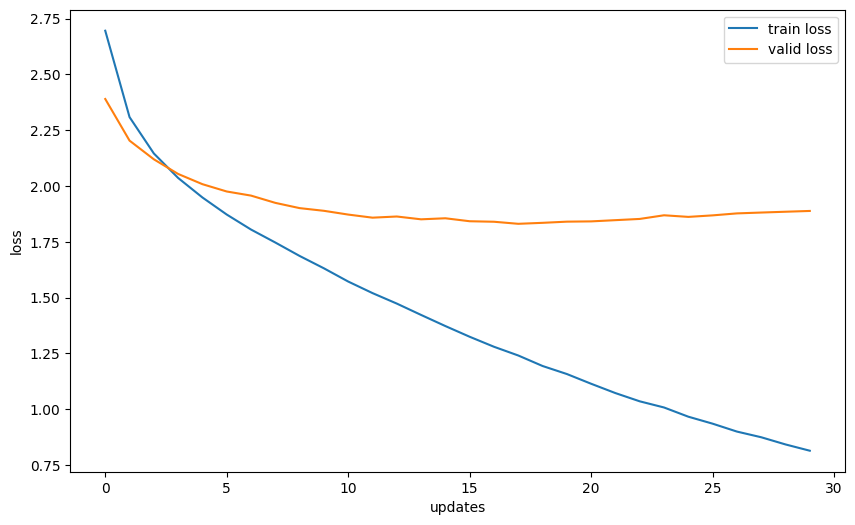

In [46]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

Text(0, 0.5, 'acc')

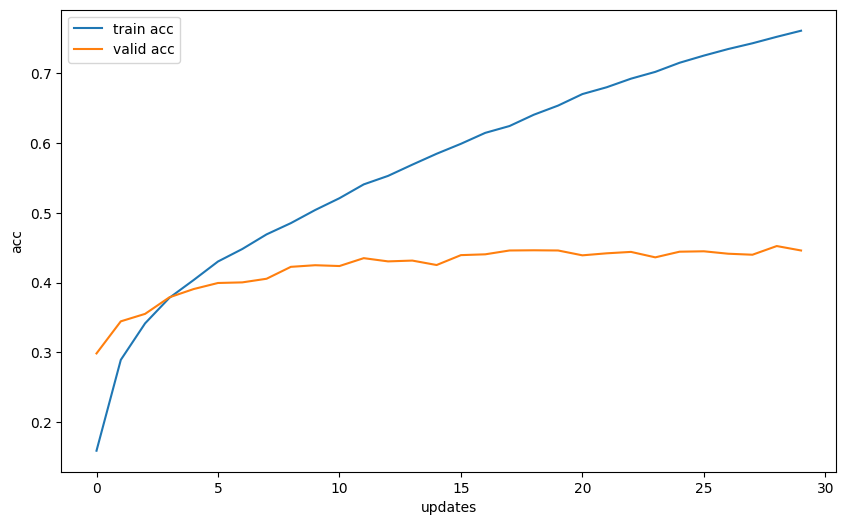

In [47]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('acc')

## Test model with test set

In [49]:
test_loss, test_acc = evaluate(model, test_loader, criterion, test_loader_length)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.880 | Test Acc: 44.22%


## Test with unseen question (you can test on below)

In [1]:
import torch, torchdata, torchtext
import re
from torchtext.data.utils import get_tokenizer
import dill

C:\Users\earth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def predict(text_str):
    text_str = text_str.lower()
    device = 'cpu'
    regex_s = re.sub("\\(.+?\\)|[\r\n|\n\r]|!", "", text_str)
    text = " ".join(regex_s.split())
    tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
    loaded_model = torch.jit.load('CNN.pt')
    with open('vocab.pkl', 'rb') as f:
        loaded_vocab = dill.load(f)
    text = torch.tensor(loaded_vocab(tokenizer(text))).to(device)
    text = text.reshape(1, -1)
    with torch.no_grad():
        output = loaded_model(text).squeeze(1)
        predicted = torch.max(output.data, 1)[1]
        return predicted

In [7]:
text = "what is the best refrigerator on your store?"
predict(text)

tensor([3])